# Overview

This Notebook is split into a few parts. The first cell is all raw data - it contains:

* The amount of XP needed to progress between specific levels, collected by hand
* XP gained for various activities. An array if used if XP is dependent on current streak or grade
* Gold gains for hourglass or emissary flags, and gold costs for supplies

After the data cell, code cells are used for:

1. Fitting a curve to the "til next level" data.
2. Fitting multiple curves to the "hourglass value" data. This is a work-in-progress.
3. IPython widgets can be used to adjust a scale and zoom into specific "til next level" ranges and estimate the required effort to progress.
4. A 1000-iteration simulator can be used to more accurately predict effort required to progress, based on win rate, flag rate, and other variables.

In [1]:
from IPython.display import display, Markdown

# [(level, XP til next level)]
# Mix of data collected by SansSariph, Lucc5822
# and /u/OndrejBakan's spreadsheet here: https://docs.google.com/spreadsheets/d/1YsY5B0N_-uSPwLl3RglJjW_pclCSkYcqVx3-BbMx3AQ/view#gid=1095730314
zippedData = [
    (1, 2000), 
    (2, 3278), 
    (3, 4033), 
    (4, 4618),
    (5, 5108),
    (6, 5535), 
    (7, 5919), 
    (8, 6267), 
    (9, 6590), 
    (10, 6890), 
    (11, 7171), 
    (12, 7437), 
    (13, 7690), 
    (14, 7929), 
    (15, 8160), 
    (16, 8381), 
    (17, 8593), 
    (18, 8797), 
    (19, 8995), 
    (20, 9187), 
    (21, 9373), 
    (22, 9552),
    (23, 9728),
    (24, 9899),
    (25, 10065), 
    (26, 10227), 
    (27, 10386), 
    (28, 10541), 
    (29, 10693), 
    (30, 10842), 
    (31, 10986), 
    (32, 11130), 
    (33, 11270), 
    (34, 11407), 
    (35, 11542), 
    (36, 11674), 
    (37, 11805),
    (38, 11934),
    (39, 12060),
    (40, 12184),
    (41, 12306),
    (42, 12428),
    (43, 12546),
    (44, 12663),
    (45, 12779),
    (46, 12894),
    (47, 13005),
    (48, 13117),
    (49, 13227),
    (50, 13335),
    (51, 13443),
    (52, 13548),
    (53, 13652),
    (54, 13757),
    (55, 13858),
    (56, 13960),
    (57, 14059),
    (58, 14159),
    (59, 14257),
    (60, 14353),
    (61, 14450),
    (62, 14545),
    (63, 14639),
    (64, 14732),
    (65, 14825),
    (66, 14916),
    (67, 15006),
    (68, 15097),
    (69, 15186),
    (70, 15274),
    (71, 15361),
    (72, 15448),
    (73, 15535),
    (74, 15619),
    (75, 15705),
    (76, 15788),
    (77, 15872),
    (78, 15954),
    (79, 16036),
    (80, 16118),
    (81, 16198),
    (82, 16279),
    (83, 16359),
    (84, 16437),
    (85, 16516),
    (86, 16593),
    (87, 16672),
    (88, 16747),
    (89, 16825),
    (90, 16900),
    (91, 16975),
    (92, 17050),
    (93, 17124),
    (94, 17199),
    (95, 17271),
    (96, 17344),
    (97, 17417),
    (98, 17489),
    (99, 17560)
]

# Static requirement after level 100
AFTER_100 = 12600

# Allegiance/XP for losing a fight
# Prior to 2.7.2 (2023-1-19), this value was 560
GAIN_LOSS = 700

# Allegiance/XP for sinking another ship
# Index == streak; if out-of-bounds, use MAX_GAIN_PER_WIN
GAIN_WIN = [
    4200,
    4675,
    5160,
    5688
]

# Every win after 4 nets this much
MAX_GAIN_PER_WIN = 6600

# Amount of allegiance gained for a win
gain_win = lambda newStreak: GAIN_WIN[newStreak-1] if newStreak <= len(GAIN_WIN) else MAX_GAIN_PER_WIN

# Allegiance/XP for cashing out an hourglass
# Index == wins/streak - 1
GAIN_HOURGLASS = [
    1100,
    2640,
    4680,
    7800,
    # 10800,
    # 13800
    # ... etc up by 3k each time
    # 10 = 25800, 12 = 31800, 17 = 46800 are confirmed numbers
]

# 0: Invalid
# 1-4: Index into GAIN_HOURGLASS by value - 1
# 5+: (x - 4) * 3000 + GAIN_HOURGLASS[-1]
gain_hourglass = lambda streak: GAIN_HOURGLASS[streak-1] if streak <= 4 else GAIN_HOURGLASS[-1] + (3000 * (streak - 4))

# Gold added to your hourglass for a win
# Index = wins/streak - 1
INCREMENTAL_HOURGLASS_GOLD = [
    10000,
    12000,
    14000,
    16000,
    20000
]

# Allegiance/XP for selling a broken emissary flag for the rival faction
# Index = flag grade - 1
GAIN_FLAG = [
    600,
    1200,
    1800,
    2400,
    3000
]

# Gold multipliers as a trading company emissary
EMISSARY_MULTIPLIERS = [
    1,    # No flag
    1,    # Grade 1
    1.33, # Grade 2
    1.67, # Grade 3
    2,    # Grade 4
    2.5   # Grade 5
]

# Averages based on SoT wiki; base value for selling a broken flag
GOLD_FLAG_SELL = [
    2000,
    4000,
    6000,
    8000,
    10000,
]

# Gold for lowering your own flag; does not scale
GOLD_FLAG_LOWER = [
    0,
    750,
    1750,
    3000,
    5000
]

SUPPLY_TYPE_MERCHANT = "Merchant"
SUPPLY_TYPE_CAPTAINCY = "Captaincy"
SUPPLY_NAME_CANNONS = "Cannonballs"
SUPPLY_NAME_PLANKS = "Planks"
SUPPLY_NAME_CRATE = "Storage crate"
SUPPLY_NAME_BOMBS = "Throwables"
SUPPLY_NAME_FRUIT = "Fruit"
SUPPLY_NAME_MEAT = "Meat"

# Gold to resupply between battles
SUPPLY_COSTS = {
    SUPPLY_TYPE_MERCHANT: {
        SUPPLY_NAME_CANNONS: 5000,
        SUPPLY_NAME_PLANKS: 3500,
        # Prior to 2.7.2 (2023-1-19), this value was 17500
        SUPPLY_NAME_CRATE: 5000
    },
    SUPPLY_TYPE_CAPTAINCY: {
        SUPPLY_NAME_CANNONS: 3500,
        SUPPLY_NAME_PLANKS: 2500,
        SUPPLY_NAME_BOMBS: 3500,
        SUPPLY_NAME_FRUIT: 3500,
        SUPPLY_NAME_MEAT: 1725
    }
}

# Helper to print markdown
displaymd = lambda s: display(Markdown(s))

# Fitting a power curve to the XP-per-level data

**[a, b, d]** where *y = a\*(x + d)<sup>b</sup>*: **[ 2.80899159e+03  3.99350715e-01 -5.57260796e-01]**

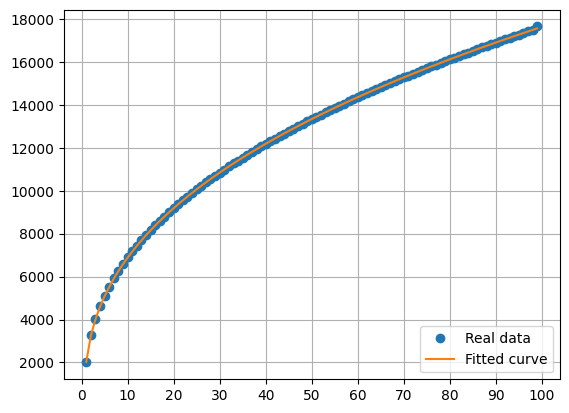

In [2]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import simpson as int_simpson, quad as int_quad
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex, Markdown
import pandas as pd
%matplotlib inline

def log_curve(x, a, b):
    return a * np.log(x) + b

def arctan_curve(x, a, b, ph, d):
    return a * np.arctan(b * x + ph)  + d

# This seems to be the winner (a + (x + d)^b)
# Keeping the other functions around for posterity
def power_curve(x, a, b, d):
    # Need to abs (x + d) because np is unhappy doing x^b if x is negative
    # We don't expect b >= 1, but it screws up the fit/test process
    return a * np.power(np.abs(x + d), b)

# Recording old fit curves for posterity in case the data changes significantly
snapshots = [
    { "date": "2022-12-10T21:22:15Z", "curve": power_curve, "params": [2.81728139e+03, 0.398507015, -0.577508009] },
    
    # After filling in most of the 60s and two 80 data points
    { "date": "2022-12-19T02:00:00Z", "curve": power_curve, "params": [2.81423065e+03, 0.398836145, -0.563087413] },
    
    { "date": "2022-12-27T03:34:00Z", "curve": power_curve, "params": [2.80905616e+03, 0.399351083, -0.557412915] },
]

curve_to_fit = power_curve

# Our data ("zippedData") is a list of (x, y) tuples which we need to rearrange
# into an x-list and y-list. We also build a "mapped" dictionary {x: y} at the same time.
lvls = []
tnlXp = []
mapped = {}
for (x, y) in zippedData:
    lvls.append(x)
    tnlXp.append(y)
    mapped[x] = y

# Fit our curve to the data; p0 is based on iteration from previous curves
pars, cov = opt.curve_fit(f=curve_to_fit, xdata=lvls, ydata=tnlXp, p0=[2800, 0.4,  -0.6], bounds=(-np.inf, np.inf))
displaymd("# Fitting a power curve to the XP-per-level data")
displaymd(f"**[a, b, d]** where *y = a\*(x + d)<sup>b</sup>*: **{pars}**")

# Generate a range of x-values over which to evaluate the curve
# We omit level 100 itself, because that seems to be slightly off-curve, likely
# due to manual adjusting by Rare.
x_fit = np.linspace(1, 99, 99)

# Evaluate the curve at each x-value in the range
y_fit = curve_to_fit(x_fit, *pars)

# Plot our real data
plt.plot(lvls, tnlXp, "o", label="Real data")
# Plot our fitted data
plt.plot(x_fit, y_fit, label="Fitted curve")
plt.xticks(np.arange(0, 101, step=10))
plt.grid(which="major")
plt.legend(loc="lower right")
plt.show()

In [3]:
import ipywidgets as widgets
import math

# For a tuple (from, to), this function computes how much XP/Allegiance is needed to progress.
# It returns a 3-tuple (real, fitted, integral):
# real: Mix of real data and fitted data where we're missing real data
# fitted: Sum of fitted data points only
# integral: Integrated fit curve
# Only "real" is practically useful, but the others are included to allow spot checks of the fit curve
def get_xp_values(levelRange):
    fromLevel, toLevel = levelRange
    
    # We'll use our curve-of-best-fit as well as our real data, where we have it.
    # Approximations counts how many times we defer to the fit line instead of using real data.
    approximations = 0
    realSum = 0
    fittedSum = 0
    for level in range(fromLevel, toLevel):
        if level >= 100:
            # XP is static from level 100 onwards, not curved
            realSum += AFTER_100
            fittedSum += AFTER_100
            continue
        
        fitted = curve_to_fit(level, *pars)
        if level in mapped:
            realSum += mapped[level]
        else:
            realSum += fitted
            approximations += 1
        fittedSum += fitted

    # Integrate the fit line for fun
    (integralSum, _error) = int_quad(lambda x: curve_to_fit(x, *pars), fromLevel, toLevel)  
    return ((realSum, approximations), fittedSum, integralSum)

# Calculate how long it takes to level over a given level range
def calculate_level_values(levelRange):
    ((realSum, approximations), fittedSum, integralSum) = get_xp_values(levelRange)
    fromLevel, toLevel = levelRange

    displaymd(f"## XP to level from {fromLevel} to {toLevel}")

    to100 = get_xp_values((1, 100))
    
    if approximations > 0:
        displaymd(f"**Best guess (real and fitted data):** {realSum:,.0f}, using {approximations:d} fitted levels")
    else:
        displaymd(f"**Real data:** {realSum:,d}")
        
    displaymd(f"**Fitted data only:** {fittedSum:,.0f}")
    
    if toLevel <= 100:
        # It's not a continuous curve and so integral has no relevance over 100
        displaymd(f"**Integral of fit curve:** {integralSum:,.0f}")

    displaymd("## Effort required")
    if fromLevel > 1 or toLevel != 100:
        displaymd(f"This is **{(100.0*realSum)/to100[0][0]:,.1f}%** of the amount to get from 1 to 100")
    farmedLossCount = math.ceil(realSum / GAIN_LOSS)
    minsPerLoss = 5
    displaymd(f"**Loss farming 👎**: {farmedLossCount:,.0f}")
    displaymd(f"Assuming {minsPerLoss} mins/loss, this is {farmedLossCount * minsPerLoss / 60.0:,.1f} hours")
    displaymd(f"**Individual wins** (no losses, hourglasses, flags, or streaks): {math.ceil(realSum / GAIN_WIN[0]):,.0f}")
    displaymd(f"**1-streak wins** (+hourglass, no losses, flags, or 'real' streaks): {math.ceil(realSum / (GAIN_WIN[0] + GAIN_HOURGLASS[0])):,.0f}")
    displaymd(f"**50/50 win/loss matches**: {math.ceil(2 * realSum / (GAIN_WIN[0] + GAIN_LOSS)):,.0f}")
    displaymd("For more nuanced estimates, see the simulator at the end of this Notebook!")

# Params are tuples of (level, progress), e.g.,
# calculate((30, 0.5), (31, 0.2)) will calculate how much XP was earned
# going from level 30 (halfway to 31) to level 31 (20% to level 32).
def calculate_earned_xp(starting_tuple, ending_tuple):
    (starting_level, starting_progress) = starting_tuple
    (ending_level, ending_progress) = ending_tuple
    
    accumulated_xp = 0
    
    # For every level we gained or skipped, calculate that XP value
    for level in range(starting_level, ending_level):
        xp_data_for_level = get_xp_values((level, level + 1))
        xp_cap_for_level = xp_data_for_level[0][0]
        
        remaining_xp_for_level = (1 - starting_progress) * xp_cap_for_level
        accumulated_xp += remaining_xp_for_level
        starting_progress = 0
        
    # End by adding how much we have left over on the last level
    last_level_data = get_xp_values((ending_level, ending_level + 1))
    last_level_xp_cap = last_level_data[0][0]
    final_xp_end = ending_progress * last_level_xp_cap # Where we ended up in this band
    final_xp_start = starting_progress * last_level_xp_cap # How much to subtract for this band
    accumulated_xp += final_xp_end - final_xp_start
    
    return accumulated_xp

levelSlider = widgets.IntRangeSlider(
    value=[1, 100],
    min=1,
    max=1000,
    step=1,
    description="Levels"
)

widgets.interact(calculate_level_values, levelRange=levelSlider);

interactive(children=(IntRangeSlider(value=(1, 100), description='Levels', max=1000, min=1), Output()), _dom_c…

In [4]:
# This cell declares a bunch of widgets used in the next cell, so that they aren't reset each time we evaluate that cell

modelSliderWidget = widgets.IntRangeSlider(
    value=levelSlider.value,
    min=1,
    max=100,
    step=1,
    description='Levels',
    continuous_update=False
)

winRateSlider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.05,
    description='Win rate:',
    continuous_update=False
)

grade1FlagWidget = widgets.BoundedFloatText(
    value=5,
    min=1,
    max=50.0,
    step=0.1,
    description='Grade 1 flag every N fights:',
)

bankSlider = widgets.IntSlider(
    value=4,
    min=1,
    max=20,
    step=1,
    description='Bank streaks:',
    continuous_update=False
)

flagSlider = widgets.FloatSlider(
    value=0.25,
    min=0,
    max=1,
    step=0.05,
    description='Flag rate:',
    continuous_update=False
)

prepTimeWinSlider = widgets.IntSlider(
    value=5,
    min=0,
    max=15,
    step=1,
    description='Prep time (wins):',
    continuous_update=False,
    style={'description_width': 'initial'}
)

prepTimeLossSlider = widgets.IntSlider(
    value=10,
    min=1,
    max=30,
    step=1,
    description='Prep time (spawn):',
    continuous_update=False,
    style={'description_width': 'initial'}
)

mmTimeSlider = widgets.IntSlider(
    value=1,
    min=0,
    max=30,
    step=1,
    description='Queue time:',
    continuous_update=False,
    style={'description_width': 'initial'}
)

gameTimeSlider = widgets.IntSlider(
    value=15,
    min=1,
    max=60,
    step=1,
    description='Match length:',
    continuous_update=False,
    style={'description_width': 'initial'}
)

merchantSuppliesButtons = widgets.SelectMultiple(
    options=[SUPPLY_NAME_CRATE, SUPPLY_NAME_CANNONS, SUPPLY_NAME_PLANKS],
    value=[SUPPLY_NAME_CRATE, SUPPLY_NAME_CANNONS, SUPPLY_NAME_PLANKS],
    description='Merchant'
)

captaincySuppliesButtons = widgets.SelectMultiple(
    options=[SUPPLY_NAME_CANNONS, SUPPLY_NAME_PLANKS, SUPPLY_NAME_BOMBS, SUPPLY_NAME_FRUIT, SUPPLY_NAME_MEAT],
    value=[SUPPLY_NAME_CANNONS, SUPPLY_NAME_PLANKS, SUPPLY_NAME_BOMBS, SUPPLY_NAME_FRUIT, SUPPLY_NAME_MEAT],
    description='Captaincy'
)

In [5]:
# This cell contains helper classes for running our simulation.

import numpy.typing as npt
from random import random
from typing import List

        
class MatchResult:
    """
    Represents the outcome of a single match along a streak.
    A match can be won or lost, the enemy may or may not be flying an emissary flag for us to capture,
    and the value of a win depends on our current streak.
    """
    
    def __init__(self, streak_before_match: int, is_win: bool, previous_wins: int, bank_at: int, seeded_flags: npt.NDArray[int]):
        """
        Initialize a MatchResult with the specified data.

        :param streak_before_match: Count of consecutive wins preceding this match
        :param is_win: True if the player won this match
        :param previous_wins: Total number of wins the player has earned in a given simulation
        :param bank_at: The win streak at which we want to cash out our hourglass
        :param seeded_flags: NumPy array of emissary flags that will be indexed into in order to get an
            emissary flag value for the current opponent.
        """
        self.streak_before_match = streak_before_match
        self.is_win = is_win
        
        self.new_streak: int = streak_before_match + 1 if is_win else 0
        
        emi_multiplier: float = 1
        if self.is_win:
            # Assume if we have 2+ unbroken wins that we're grade 5 emissary, otherwise grade 3
            # In practice, grade 4 after 1 win is also possible, but we'll be conservative
            emi_grade = 3 if streak_before_match <= 0 else 5
            self.emi_multiplier = EMISSARY_MULTIPLIERS[emi_grade]
            
            # Get the value of the enemy's flag, which we just captured. 0 means no flag.
            self.enemy_flag: int = seeded_flags[previous_wins]
            if self.enemy_flag > 0:
                # Award gold for selling flag
                self.flag_gold = self.emi_multiplier * GOLD_FLAG_SELL[self.enemy_flag - 1]
                self.flag_allegiance = GAIN_FLAG[self.enemy_flag - 1]
            else:
                self.flag_gold = 0
                self.flag_allegiance = 0
                
            # Do we bank this win?
            self.should_bank = self.new_streak >= bank_at
    
    @property
    def captured_enemy_flag(self) -> bool:
        """Whether we won and the enemy had an emissary flag."""
        return self.is_win and self.enemy_flag > 0
    
    @property
    def match_allegiance(self) -> int:
        """How much allegiance we earned immediately for finishing this match."""
        if self.is_win:
            return gain_win(self.new_streak)
        else:
            return GAIN_LOSS
        
    @property
    def match_hourglass_gold(self) -> int:
        """How much gold got added to our hourglass?"""
        if self.is_win:
            return INCREMENTAL_HOURGLASS_GOLD[min(self.streak_before_match, len(INCREMENTAL_HOURGLASS_GOLD) - 1)]
        else:
            return 0

class Sim:
    """
    Tracks stats around wins, losses, allegiance, gold, etc over the course of simulating matches to reach
    a specific amount of allegiance.
    """
    
    def __init__(
        self,
        max_allegiance: int,
        win_rate: float,
        resupply_cost: int,
        bank_at: int,
        grade_rates: List[int],
        time_prep_win: int,
        time_prep_spawn: int,
        time_queue: int,
        time_match: int
    ):
        """
        Initializes a simulation with the specified data.
        
        :param max_allegiance: Exclusive allegiance value we want to hit in this simulation
        :param win_rate: How often we win
        :param resupply_cost: Gold spent to resupply after a loss and at the start of a session
        :param bank_at: Win streak at which we'll bank our hourglasses
        :param grade_rates: The frequencies at which an enemy will have specific emissary flag grades
        :param time_win: Average minutes spent prepping/looting between wins
        :param time_loss: Average minutes spent prepping/supplying after a loss or on spawn
        :param time_queue: Average minutes spent in queue
        :param time_match: Average minutes spent in each match
        """
        self.total_allegiance = 0 # We'll sim until this exceeds our requirement
        self.max_allegiance = max_allegiance
        self.win_rate = win_rate
        self.resupply_cost = resupply_cost
        self.bank_at = bank_at
        
        self.banked_hourglasses = 0 # Number of banked hourglasses
        self.lost_streaks = 0 # Number of hourglasses we lost
        self.max_streak = 0 # Largest win streak (separate from banked hourglasses)
        self.wins = 0 # Total wins
        self.losses = 0 # Total losses
        
        self.current_streak = 0 # Current hourglass streak
        self.current_streak_unbanked = 0 # Current win streak (separate from hourglasses)
        
        # TODO: Gold for lowering flags? Is that even worth tracking?
        self.total_resupplies = 1 # Gold spent on resupplies; accumulates per loss
        self.current_hourglass_gold = 0 # Current (unbanked) hourglass value
        self.banked_hourglass_gold = 0 # Total gold we've earned from banking hourglasses
        self.banked_flag_gold = 0 # Total gold we've earned from selling emissary flags
        self.flags_sold = [0, 0, 0, 0, 0] # Count of each flag grade we've sold
        
        self.time_prep_win = time_prep_win
        self.time_prep_spawn = time_prep_spawn
        self.time_queue = time_queue
        self.time_match = time_match
        self.total_time_prepping = 0
        self.total_time_in_queue = 0
        self.total_time_in_match = 0
        
        # Generate a large number of samples that represents emissary flag grades our enemies will use;
        # we'll pull from this list whenever we win a match.
        # We do this up front to save on perf, as generating a sample just-in-time is very expensive.
        self.enemy_flag_grades = np.random.choice([0, 1, 2, 3, 4, 5], 1000, True, grade_rates)

    def step(self) -> MatchResult:
        """Runs one match of the simulation."""
        
        self.total_time_in_queue += self.time_queue
        
        is_win = random() < self.win_rate
        result = MatchResult(self.current_streak, is_win, self.wins, self.bank_at, self.enemy_flag_grades)

        self.total_time_in_match += self.time_match
        
        self.total_allegiance += result.match_allegiance
        self.current_streak = result.new_streak
        
        if result.is_win:
            self.wins += 1
            self.current_hourglass_gold += result.match_hourglass_gold

            # Sell the flag; add allegiance and gold and bump our counters
            # TODO: Option to let flags ride instead of selling immediately
            self.total_allegiance += result.flag_allegiance
            self.banked_flag_gold += result.flag_gold
            if result.captured_enemy_flag:
                self.flags_sold[result.enemy_flag - 1] += 1
                self.total_allegiance += GAIN_FLAG[result.enemy_flag - 1]

            # Do we bank this win?
            self.current_streak_unbanked += 1
            self.max_streak = max(self.current_streak_unbanked, self.max_streak)
            if result.should_bank:
                self.total_allegiance += gain_hourglass(self.current_streak)
                self.banked_hourglass_gold += result.emi_multiplier * self.current_hourglass_gold
                self.banked_hourglasses += 1

                # Reset since we just banked
                self.current_streak = 0 
                self.current_hourglass_gold = 0
        else:
            self.losses += 1
            if result.streak_before_match >= 1:
                self.lost_streaks += 1
            self.max_streak = max(self.current_streak_unbanked, self.max_streak)

            self.current_streak = 0
            self.current_streak_unbanked = 0
            self.current_hourglass_gold = 0
            self.total_resupplies += 1
            
        return result
        
    def sim(self):
        """Runs the simulation."""
        won_last_match = False
        while self.total_allegiance < self.max_allegiance:
            self.total_time_prepping += self.time_prep_win if won_last_match else self.time_prep_spawn
            result: MatchResult = self.step()
            won_last_match = result.is_win

In [6]:
def calculate_modeled_data(
    level_range,
    win_rate,
    bank_at,
    flag_rate,
    merchant_supplies,
    captaincy_supplies,
    prep_time_win,
    prep_time_loss,
    mm_time,
    game_time
):
    fromLevel, toLevel = level_range
    if fromLevel == toLevel:
        displaymd("The starting and ending level need to be different values in order to sim.")
        return
    
    grade_rates = [1 - flag_rate, flag_rate*0.5, flag_rate*0, flag_rate*0.125, flag_rate*0.125, flag_rate*0.25]
    
    ((realSum, approximations), fittedSum, integralSum) = get_xp_values(level_range)
    
    # Compute cost to do a full resupply each match
    resupply_cost = 0
    for supply in merchant_supplies:
        resupply_cost += SUPPLY_COSTS[SUPPLY_TYPE_MERCHANT][supply]
    for supply in captaincy_supplies:
        resupply_cost += SUPPLY_COSTS[SUPPLY_TYPE_CAPTAINCY][supply]
    
    displaymd(f"## Sim from {fromLevel} to {toLevel}; {realSum:,.0f} XP required")
    displaymd(f"Assuming a win rate of **{win_rate}**")
    displaymd(f"Banking hourglasses at **{bank_at}** wins")
    displaymd(f"Assuming **{resupply_cost:,d}** gold to resupply each loss")
    displaymd(f"Assuming {EMISSARY_MULTIPLIERS[3]}x gold for grade 3 (1 win); {EMISSARY_MULTIPLIERS[5]}x for grade 5 (2+ wins)")
    displaymd(f"Assuming 0 bonus gold for sinking champions") # TODO?
    displaymd(f"Using the following weights for chances of each flag grade (first is no flag): **{grade_rates}**")
    
    # Computes various stats for a run from "fromLevel" to "toLevel" and returns them in a dictionary
    def sim():
        this_sim = Sim(
            realSum,
            win_rate,
            resupply_cost,
            bank_at,
            grade_rates,
            prep_time_win,
            prep_time_loss,
            mm_time,
            game_time
        )
        this_sim.sim()

        flags_sold = this_sim.flags_sold
        # Return a dictionary of stuff we might care about for analysis
        return { "Wins": this_sim.wins, "Losses": this_sim.losses,
                "MaxStreak": this_sim.max_streak, "BankedStreaks": this_sim.banked_hourglasses, "LostStreaks": this_sim.lost_streaks,
                "ResupplySpend": this_sim.total_resupplies * float(this_sim.resupply_cost), "HourglassGold": this_sim.banked_hourglass_gold, "SoldFlagsGold": this_sim.banked_flag_gold,
                "TimePrepping": this_sim.total_time_prepping, "TimeInQueue": this_sim.total_time_in_queue, "TimeInMatch": this_sim.total_time_in_match,
                "FlagsSold_1": flags_sold[0], "FlagsSold_2": flags_sold[1], "FlagsSold_3": flags_sold[2], "FlagsSold_4": flags_sold[3],"FlagsSold_5": flags_sold[4]}
    
    
    # Run 1000 trials and do some data magic
    data = pd.DataFrame([sim() for _ in range(1000)]);
    data["TotalNetGold"] = data["HourglassGold"] + data["SoldFlagsGold"] - data["ResupplySpend"]
    data["TotalHours"] = (data["TimePrepping"] + data["TimeInQueue"] + data["TimeInMatch"]) / 60
    data["NetGoldPerMatch"] = data["TotalNetGold"] / (data["Wins"] + data["Losses"])
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data[["Wins", "Losses", "TotalHours", "NetGoldPerMatch", "TotalNetGold", "HourglassGold", "SoldFlagsGold", "ResupplySpend"]].describe()
                .drop(["count", "25%", "75%"]) # Not interested in these rows
                .reindex(["mean", "50%", "min", "max", "std"])) # Rearrange 
        
    data.plot.hist(column=["Wins", "Losses"], bins=range(0, 300), grid=True)
    
    print()
    
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data.head())
    
widgets.interact_manual(
    calculate_modeled_data,
    level_range=modelSliderWidget,
    win_rate=winRateSlider,
    bank_at=bankSlider,
    flag_rate=flagSlider,
    merchant_supplies=merchantSuppliesButtons,
    captaincy_supplies=captaincySuppliesButtons,
    prep_time_win=prepTimeWinSlider,
    prep_time_loss=prepTimeLossSlider,
    mm_time=mmTimeSlider,
    game_time=gameTimeSlider
);

interactive(children=(IntRangeSlider(value=(1, 100), continuous_update=False, description='Levels', min=1), Fl…

In [7]:
start_level = widgets.BoundedIntText(
    value=50,
    min=1,
    max=1000,
    step=1,
    description='Start level:',
    disabled=False
)

start_progress = widgets.BoundedFloatText(
    value=0,
    min=0,
    max=1,
    description='Start progress:',
    disabled=False
)

end_level = widgets.BoundedIntText(
    value=50,
    min=1,
    max=1000,
    step=1,
    description='End level:',
    disabled=False
)

end_progress = widgets.BoundedFloatText(
    value=0,
    min=0,
    max=1,
    description='End progress:',
    disabled=False
)

def compute_gain(start_level, start_progress, end_level, end_progress):
    delta = calculate_earned_xp((start_level, start_progress), (end_level, end_progress))
    delta = round(delta, 4)
    displaymd(f"Earned **{delta}** XP")

widgets.interact(compute_gain, start_level=start_level, start_progress=start_progress, end_level=end_level, end_progress=end_progress);

interactive(children=(BoundedIntText(value=50, description='Start level:', max=1000, min=1), BoundedFloatText(…